In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import sqrt
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
%matplotlib inline
import time

In [2]:
train_df = pd.read_csv("../features/train.csv", low_memory=False)
test_df = pd.read_csv("../features/test.csv", low_memory=False)
data = pd.read_csv("data_set.csv", low_memory = False)

In [3]:
train_df = train_df[['id','precio']]
#train_df['precio'].value_counts()

In [4]:
print(data.shape)
print(test_df.shape)
print(train_df.shape)

(300000, 180)
(60000, 22)
(240000, 2)


In [5]:
features = pd.merge(train_df, data, on='id', how='inner')

In [6]:
features.not_outlier.value_counts()

1.0    215351
0.0     24649
Name: not_outlier, dtype: int64

In [7]:
type(features.loc[0].not_outlier)

numpy.float64

In [8]:
filter_name = 'not_outlier'
features = features[features[filter_name] == True]
features.shape
#features.not_outlier.value_counts()

(215351, 181)

In [9]:
features = features.fillna(0)

In [10]:
labels = features['precio']
features = features.drop(['id','precio'], axis=1)
features = features.drop(['Local en centro comercial', 'Local Comercial', 'desc_comedor', 'desc_frente', 'desc_transport', 'desc_amoblado', 'Nave industrial', 'Casa uso de suelo', 'Departamento Compartido', 'titulo_escuela', 'desc_ambientes', 'Huerta', 'titulo_avenida', 'desc_vende', 'Inmuebles productivos urbanos', 'titulo_zona', 'escuelascercanas', 'Quinta Vacacional', 'titulo_alquila', 'desc_auto', 'titulo_frente', 'desc_alquila', 'desc_anhelo', 'Villa', 'Otros', 'desc_zona', 'dia', 'mes', 'avenida', 'desc_avenida', 'desc_amenities_lujo', 'titulo_positiva', 'avenue_en_desc', 'titulo_anhelo', 'titulo_vende', 'titulo_amoblado', 'titulo_terminado', 'titulo_antiguedad', 'titulo_amenities_lujo', 'Desconocida', 'titulo_gym', 'titulo_auto', 'titulo_pago', 'Duplex', 'Lote', 'titulo_comedor', 'titulo_estudio', 'titulo_pileta', 'Garage', 'Hospedaje', 'titulo_transport'], axis=1)



In [11]:
features.shape

(215351, 128)

In [12]:
#prev:
#{'colsample_bytree': 0.7, 
#'learning_rate': 0.05, 
#'max_depth': 7, 
#'min_child_weight': 4, 
#'n_estimators': 500, 
#'nthread': 4, 
#'objective': 'reg:linear', 
#'silent': 1, 
#'subsample': 0.7}

#got with:
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}


#replace with current best:
parameters = {'nthread':[4], 
              'objective':['reg:squarederror'],
              'learning_rate': [0.05], 
              'max_depth': [10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb = xgb.XGBRegressor(objective='reg:squarederror')

In [13]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)


In [14]:
start_time = time.time()
xgb_grid.fit(features, labels)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed: 13.2min finished
C:\Users\G-Tune Robinson\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\G-Tune Robinson\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_st...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.05, 0.06], 'max_depth': [8, 10],
                   

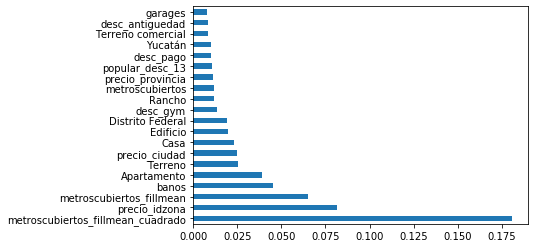

In [15]:
feat_importances = pd.Series(xgb_grid.best_estimator_.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [16]:
df_feat_importances = pd.DataFrame(feat_importances).reset_index().rename(columns={'index':'feature',0:'importance'})
df_feat_importances = df_feat_importances.sort_values(by='importance',ascending=False)
df_feat_importances.to_csv('feature_importances_rob.csv',index=False)

In [17]:
print("--- %s seconds ---" % (time.time() - start_time))
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

--- 1099.8433766365051 seconds ---
0.83971484999704
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [18]:
set_test = pd.merge(data, test_df[['id']],on = "id", how = "inner")
ids = set_test["id"]
set_test = set_test.drop(columns=['id'])
set_test = set_test.drop(['Local en centro comercial', 'Local Comercial', 'desc_comedor', 'desc_frente', 'desc_transport', 'desc_amoblado', 'Nave industrial', 'Casa uso de suelo', 'Departamento Compartido', 'titulo_escuela', 'desc_ambientes', 'Huerta', 'titulo_avenida', 'desc_vende', 'Inmuebles productivos urbanos', 'titulo_zona', 'escuelascercanas', 'Quinta Vacacional', 'titulo_alquila', 'desc_auto', 'titulo_frente', 'desc_alquila', 'desc_anhelo', 'Villa', 'Otros', 'desc_zona', 'dia', 'mes', 'avenida', 'desc_avenida', 'desc_amenities_lujo', 'titulo_positiva', 'avenue_en_desc', 'titulo_anhelo', 'titulo_vende', 'titulo_amoblado', 'titulo_terminado', 'titulo_antiguedad', 'titulo_amenities_lujo', 'Desconocida', 'titulo_gym', 'titulo_auto', 'titulo_pago', 'Duplex', 'Lote', 'titulo_comedor', 'titulo_estudio', 'titulo_pileta', 'Garage', 'Hospedaje', 'titulo_transport'], axis=1)


In [19]:
set_test = set_test.fillna(0)

In [20]:
set_test.head()

,habitaciones,banos,Apartamento,Bodega comercial,Casa,Casa en condominio,Edificio,Oficina comercial,Rancho,Terreno,...,dolar,habxmetros,habxmetroscub,banosxmetros,banosxmetroscub,banosxhab,largotitulo,precio_ciudad,precio_provincia,precio_idzona
0,3.0,4.0,0,0,1,0,0,0,0,0,...,12.7325,0.000000,0.010000,0.000000,0.013333,0.0,49.0,4.496526e+06,3.471705e+06,0.000000e+00
1,1.0,1.0,1,0,0,0,0,0,0,0,...,16.5000,0.014925,0.014925,0.014925,0.014925,1.0,36.0,2.028803e+06,2.036020e+06,2.684120e+06
2,2.0,2.0,1,0,0,0,0,0,0,0,...,15.3775,0.020000,0.022989,0.020000,0.022989,2.0,78.0,3.407009e+06,3.471705e+06,2.726905e+06
3,2.0,2.0,1,0,0,0,0,0,0,0,...,15.3488,0.023256,0.023256,0.023256,0.023256,1.0,33.0,2.585813e+06,2.548742e+06,1.465647e+06
4,2.0,1.0,0,0,1,0,0,0,0,0,...,13.3803,0.026316,0.025000,0.013158,0.012500,2.0,56.0,9.147382e+05,2.762465e+06,9.399999e+05


In [21]:
preds_kaggel_knn = xgb_grid.predict(set_test)

In [22]:
df_kaggel_knn = pd.DataFrame(preds_kaggel_knn)
df_kaggel_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 1 columns):
0    60000 non-null float32
dtypes: float32(1)
memory usage: 234.5 KB


In [23]:
df_kaggel_knn = pd.DataFrame(df_kaggel_knn)

In [24]:
df_kaggel_knn.head()

,0
0,4889391.000
1,1094262.625
2,2412659.250
3,1213868.625
4,733024.375


In [25]:
# df_kaggel_knn = df_kaggel_knn.to_frame()# df_kagg 
df_kaggel_knn["id"] = ids
df_kaggel_knn.rename(columns = {0: 'target'},inplace = True) 
df_kaggel_knn = df_kaggel_knn[['id','target']]

In [26]:
df_kaggel_knn.head()

,id,target
0,4941,4889391.000
1,51775,1094262.625
2,115253,2412659.250
3,299321,1213868.625
4,173570,733024.375


In [27]:
df_kaggel_knn.to_csv('ResultadosXGB_without_outliers.csv',index=False)

In [28]:
df_kaggel_knn.shape

(60000, 2)

In [29]:
df_kaggel_knn.head()

,id,target
0,4941,4889391.000
1,51775,1094262.625
2,115253,2412659.250
3,299321,1213868.625
4,173570,733024.375
